# Theoretical Aspects

## Definition

Reinforcement learning (RL) is an area of machine learning concerned with how software agents ought to take actions in an environment in order to maximize the notion of cumulative reward - Wikipedia

### Q-learning

Is a model-free reinforcement learning algorithm to learn a policy telling an agent what action to take under what circumstances - Wikipedia

Q-learning creeaza un tabel a carui linii sunt starile sistemului si coloanele sunt actiunile numit Q-Table. Acest tabel contine valori astfel incat daca sistemul se afla intr-o stare, se alege actiunea care maximizeaza aceasta valoare Q.

Valorile din Q-Table se modifica in functie de:
- Vechea valoarea a lui Q
- reward-ul la un moment dat (dintr-o stare si o actiune)
- Cea mai mare valoare a lui Q din urmatoarea stare (la care se aplica un factor de discount)

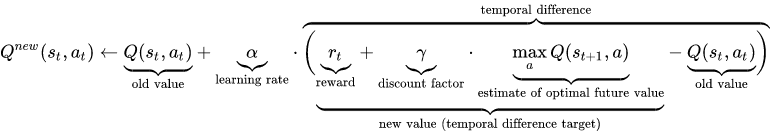

### Deep Q-Learning

Deep Q learning este un algoritm de invatare care se bazeaza pe metoda Q-learning, singura diferenta fiind ca, Q-Table, este invatat de un model in loc sa fie calculat.

Aceasta metoda este mai eficienta (din punct de vedere al memoriei) decat Q-learning pentru ca un Q-Table este extrem de mare.

Spre exemplu, in cazul 2048:
Daca Tile maxim este 2048 si dimensiunea tablei este 4x4 atunci exista:
- 44 * 10^15 starti

Deci, tabelul va avea 44 * 10^15 linii si 4 coloane (cele 4 miscari posibile) => 44 * 10^15 * 4 intrari in tabel

# Approach

Au fost incercate mai mult approach-uri pentru rezolvarea problemei.

Toate approach-urile au la baza Deep Q-Learning.

Au fost incercate diferite encodari ale starilor, diferite functii de reward si diferite modele.

## Code

Codul prezentat va fi doar cel din cea mai buna abordare.

Intregul cod se gaseste in arhiva trimisa. Codul este impartit in diferite pachete. Fiecare pachet va contine unul (sau mai multe) `main_class` unde se ruleaza antrenarea / experimentul, o implementare a modelului de baza si rezultatele + fisierele modelelor care pot fi incarcate in fisierele existente in pachete. Pachetele sunt:

- base: reprezinta clasele de baza pentru model
- games: reprezinta jocul + variatii ale jocului (stari + custom score)
- ui: implementarea UI-ului
- convolution_model: Modelul care a dat cele mai bune rezultate (foloseste o retea cu convolutional layers)
- deep_q_learning_model_64_32_package: Model cu 2 layere Dense cu 64 si 32 unitati + experimentele 
- deep_q_learning_model_128_32_8_package: Model cu 3 layere cu 128, 32 si 8 unitati + custom reward + experimente
- deep_q_learning_model_128_64_32_package: Model cu 3 layere cu 128, 64 si 32 unitati + custom reward + experimente
- deep_q_learning_mdoel_300_300_200_200_100_100_60_60_package: Model cu 8 layere cu 300, 300, 200, 200, 100, 100, 60 si 60 unitati + custom reward + experimente
- deep_q_learning_model_300_300_200_200_100_package: Model cu 5 layere cu 300, 300, 200, 200 si 100 unitati + custom reward + experimente
- deep_q_learning_model_300_300_200_200_100_regularization: Model cu 5 layere cu 300, 300, 200, 200, si 100 unitati + kernel regularization + custom reward + experimente
- deep_q_learning_model_300_300_dueling_max_regularization: Model cu 6 layere cu 300, 300, 200, 200, 100 si 100 unitati + dueling layer cu 60 unitati (PS: nu stiu daca este folosit corect) + custom reward + experimente
- deep_q_learning_model_1024_512_256_128_package: Model cu 4 layere cu 1024, 512, 256 si 128 unitati + custom reward + experimente
- deep_q_learning_model_1024_512_256 package: Model cu 3 layere cu 1024, 512 si 256 unitati + experimente

PS: Not best naming :)

Codul a fost dezvoltat intr-un IDE (PyCharm) si a fost copiat in acest jupyter notebook doar pentru a putea fi prezentat. 

Explicatii pentru fiecare clasa din cod se va face inaintea definirii fiecarei bucati de cod.

Se explica modelul, reward-ul + flow-ul inaintea codului modelului

### Prezentarea celei mai bune abordari


In [2]:
# Install packages
import sys
!{sys.executable} -m pip install keras

  Using cached Keras-2.3.1-py2.py3-none-any.whl (377 kB)
  Using cached PyYAML-5.3.1-cp36-cp36m-win_amd64.whl (215 kB)


In [13]:
# Imports
import numpy as np
from numpy import array, zeros, rot90
import os
from os import path
import math
import random
from random import randint
import copy
import keras
from keras.layers import Conv2D, Flatten, Dense
from keras.models import Sequential
from keras.optimizers import RMSprop

# Only for UI
from tkinter import *


UI pentru vizualizare

Exista 2 clase:

- NoUI <-- Nu se foloseste niciun UI. Se utilizeaza la training
- DrawUI <-- Se foloseste TKinter pentru a desena board-ul si tile-urile

In [14]:
# UI

SIZE = 800
GRID_LEN = 4
GRID_PADDING = 10

BACKGROUND_COLOR_GAME = "#92877d"
BACKGROUND_COLOR_CELL_EMPTY = "#9e948a"
SCORE_TEXT_COLOR = "#7CFC00"
BACKGROUND_COLOR_DICT = {2: "#eee4da", 4: "#ede0c8", 8: "#f2b179", 16: "#f59563", \
                         32: "#f67c5f", 64: "#f65e3b", 128: "#edcf72", 256: "#edcc61", \
                         512: "#edc850", 1024: "#edc53f", 2048: "#edc22e"}

CELL_COLOR_DICT = {2: "#776e65", 4: "#776e65", 8: "#f9f6f2", 16: "#f9f6f2", \
                   32: "#f9f6f2", 64: "#f9f6f2", 128: "#f9f6f2", 256: "#f9f6f2", \
                   512: "#f9f6f2", 1024: "#f9f6f2", 2048: "#f9f6f2"}

FONT = ("Verdana", 40, "bold")


class NoUI:
    def draw_board(self, board, score):
        pass

    def init_board(self, board):
        pass

    def destroy(self):
        pass


class DrawUI:
    def __init__(self):
        self.grid_cells = []
        self.tk = Tk()
        self.__init_grid()

    def __init_grid(self):
        self.tk.grid()
        self.background = Frame(master=self.tk, bg=BACKGROUND_COLOR_GAME, width=SIZE, height=SIZE)
        self.background.grid(row=0)
        for i in range(GRID_LEN):
            grid_row = []
            for j in range(GRID_LEN):
                cell = Frame(self.background, bg=BACKGROUND_COLOR_CELL_EMPTY, width=SIZE / GRID_LEN, height=SIZE / GRID_LEN)
                cell.grid(row=i, column=j, padx=GRID_PADDING, pady=GRID_PADDING)
                t = Label(master=cell, text="", bg=BACKGROUND_COLOR_CELL_EMPTY, justify=CENTER, font=FONT, width=4,
                          height=2)
                t.grid()
                grid_row.append(t)

            self.grid_cells.append(grid_row)
        self.__create_text()
        self.tk.grid_columnconfigure(0, weight=1)
        self.tk.grid_columnconfigure(1, weight=1)

    def __create_text(self):
        cell = Frame(self.tk, bg=BACKGROUND_COLOR_GAME)
        cell.grid(row=1, sticky='ew')
        t = Label(master=cell, text="Score: 0", bg=BACKGROUND_COLOR_CELL_EMPTY, fg=SCORE_TEXT_COLOR, justify=CENTER, font=FONT)
        t.pack()
        self.text = t

    def __update_grid_cells(self, board, score):
        for i in range(GRID_LEN):
            for j in range(GRID_LEN):
                new_number = board[i][j]
                if new_number == 0:
                    self.grid_cells[i][j].configure(text="", bg=BACKGROUND_COLOR_CELL_EMPTY)
                else:
                    self.grid_cells[i][j].configure(text=str(new_number), bg=BACKGROUND_COLOR_DICT[new_number],
                                                    fg=CELL_COLOR_DICT[new_number])
        self.text.configure(text=str(score), bg=BACKGROUND_COLOR_GAME, fg=SCORE_TEXT_COLOR)
        self.tk.update_idletasks()

    def draw_board(self, board, score):
        # Update the drawing
        self.__update_grid_cells(board, score)
        # Draw the board
        self.tk.update()
        # Give it a delay
        self.tk.after(60)

    def init_board(self, board):
        self.__update_grid_cells(board, 0)
        self.tk.update()
        self.tk.after(5)

    def destroy(self):
        self.tk.after(500)
        self.tk.destroy()


Codul care contine jocul

- Board-ul
- Posibilitatea de a face cele 4 miscari
- Array cu toate miscarile posibile la un anumit moment (un board)
- Initializarea (board cu 2 valori random de 2 sau 4 - 90% - 2 10% - 4)
- Scor - scorul creste cand se unesc 2 tile-uri
- Utilizrea UI-ului

In [15]:
# Base game
# Game class
class game_2048:
    def __init__(self, board_size=4, show_ui=False):
        self.board_size = board_size
        self.__initialize(show_ui=show_ui)

    # Initializes the game with 1 random values already on board
    def __initialize(self, show_ui):
        # Initialize the game
        self.board = zeros((self.board_size, self.board_size), dtype=np.int)
        self.fill_cell()
        self.fill_cell()

        # self.__calculate_available_moves()
        self.__calculate_available_moves()
        self.score = 0
        if show_ui:
            self.ui = DrawUI()
        else:
            self.ui = NoUI()
        self.ui.init_board(self.board)

    def __calculate_available_moves(self):
        available_moves = []
        for i in range(0, 4):  # 4 possible moves
            new_board = self.__move(i)
            if not (new_board == self.board).all():
                available_moves.append(i)

        self.available_moves = available_moves

    # Reset the game no an initial state (so no new game instance is being created)
    def reset_game(self):
        self.__initialize()

    def get_score(self):
        return self.score

    def get_highest_value(self):
        return sorted(list(self.board.flatten()), reverse=True)[0]

    # Make a move and return the new board
    def __move(self, direction, add_score=False):
        # 0: Left, 1: Up, 2: Right, 3: Down
        rotated_board = rot90(self.board, direction)
        cols = [rotated_board[i, :] for i in range(self.board_size)]
        new_board = array([self.move_left(col, add_score) for col in cols])

        return rot90(new_board, -direction)

    # Completes 1 whole game round
    # 1 round means making the move (if possible)
    # and adding 1 new random value of 2 on the board
    def do_game_round(self, direction):
        if direction not in self.available_moves:
            return False
        self.board = self.__move(direction, True)
        self.fill_cell()
        self.__calculate_available_moves()
        self.__draw()

        return True

    # Tells if the game can continue or it's done (no more available moves)
    def is_game_over(self):
        if len(self.available_moves) == 0 or np.isin(2048, self.board):
            self.ui.destroy()
            return True
        return False

    def get_board(self):
        return self.board

    def get_available_moves(self):
        return self.available_moves

    def get_state(self):
        # This should be the game state implementation for AI. It may be moved to game_ai class. TBD
        raise NotImplemented("Implement this method. Inherit from main class game_2048")

    # Adds a random value of 2 on the current board
    def fill_cell(self):
        i, j = (self.board == 0).nonzero()
        if i.size != 0:
            rnd = randint(0, i.size - 1)
            self.board[i[rnd], j[rnd]] = 2 * ((random.random() > .9) + 1)

    # Makes a move to the left.
    # It is the only needed move as making other moves will rotate the whole board
    # so that a move left is needed then it is rotated back
    def move_left(self, col, add_score=False):
        new_col = zeros(4, dtype=col.dtype)
        j = 0
        previous = None
        for i in range(col.size):
            if col[i] != 0:
                if previous is None:
                    previous = col[i]
                else:
                    if previous == col[i]:
                        new_col[j] = 2 * col[i]
                        if add_score:
                            self.score += new_col[j]
                        j += 1
                        previous = None
                    else:
                        new_col[j] = previous
                        j += 1
                        previous = col[i]

        if previous is not None:
            new_col[j] = previous

        return new_col

    def __draw(self):
        self.ui.draw_board(self.board, self.score)


Extensie a jocului care contine, in plus, functia care returneaza starea.
In cazul acesta, starea reprezinta un o matrice de 4x4 (board-ul) unde fiecare valoare din matrice reprezinta un array cu 16 elemente care va contine doar valori de 0 si 1, o singura valoare de 1, pe puterea lui 2 reprezentativa valorii de pe acel tile

In [16]:
# Game with implemented state
class game_2048_power_16(game_2048):
    def get_state(self):
        return self.create_state()

    def create_state(self):
        powers = np.zeros(shape=(4, 4, 16), dtype=np.float32)
        for i in range(self.board_size):
            for j in range(self.board_size):
                if self.board[i][j] == 0:
                    powers[i][j][0] = 1.0
                else:
                    power = int(math.log(self.board[i][j], 2))
                    powers[i][j][power] = 1.0

        return powers

Valori default (si cele folosite) sunt:
- Epsilon - 0.1 (valoarea finala de randomness folosita)
- Gamma - 0.9 (valoarea discount-ului)
- max_replay_memory - 5000 (valoarea maxima a replay memory-ului)
- epsilon_steps - 500000 (numarul de pasi in care epsilon va ajunge de la 100% la 10%)
- batch_size - 512 (dimensiunea unui batch din replay memory care se va folosi la antrenare)

init_model - initializarea modelului si incarcarea acestuia din fisier (daca exista) 
Modelul:
- Layer1 (Input): Conv2D, 128 filtre, kernel size (3, 3), activation ReLu
- Layer2: Conv2D, 64 filtre, kernel size (2, 2), activation ReLu
- Layer3: Flatten
- Layer4: Dense, 256 unitati, activation ReLu
- Layer5: Dense, 128 unitati, activation ReLu
- Layer6: Dense, 64 unitati, activation ReLu
- Layer7 (Output): Dense, 4 unitati (cele 4 actiuni posibile)
- Optimizer: RMSProp cu learning rate = 0.001
- Loss: Mean Squared Error (mse)

Functia de reward:

Functia de reward ia in considerare 2 aspecte:
- Valoarea maxima existenta in starea urmatoare
- Diferenta dintre numarul de valori de 0 dintre starea urmatoare si starea curenta (numarul de merge-uri)

Astfel:
- Daca maximul urmator este diferit (mai mare) decat maximul curent atunci atunci se ia puterea acestuia si se adauga la reward 10% (0.1) din aceasta valoare, altfel se adauga 0 la reward
- Se adauga la reward numarul de merge-uri dintre cele 2 stari (urmatoarea si curenta)

Functia get_action

Va returna o actiune si va antrena modelul (cand este cazul)

Pasi:
- Se foloseste modelul pentru a face prediction pentru cele 4 valori Q din starea curenta
- Se sorteaza (descrescator) aceste valori si se iau indecsii (valori ale actiunilor)
- Se genereaza un numar random intre 0 si 1
- Se valideaza numarul cu epsilon (pentru a vedea daca se alege o actiune random)
- Daca actiunea este random atunci:
    - Se alege o actiune random din cele posibile
    - Se aplica aciunea pe starea curenta pentru a avea urmatoarea stare
    - Se calculeaza reward-ul
    - Se foloseste modelul pentru a face prediction pentru cele 4 q-values din starea urmatoare
    - Se ia valoarea maxima din acele 4 valori
    - Label-ul pentru actiunea aleasa devine: reward + discount * valoarea maxima din urmatoarea stare
- Daca actiunea nu este random atunci:
    - Se ia actiunea cu cel mai mare Q value
    - Se aplica aciunea pe starea curenta pentru a avea urmatoarea stare
    - Se calculeaza reward-ul
    - Se foloseste modelul pentru a face prediction pentru cele 4 q-values din starea urmatoare
    - Se ia valoarea maxima din acele 4 valori
    - Label-ul pentru actiunea aleasa devine: reward + discount * valoarea maxima din urmatoarea stare
- Se face update valorii curente a lui epsilon
- Se adauga starea si label-urile calulate (cele deuja predicted + valoarea modificata) in replay memory
- Daca am ajuns la lungimea maxima a replay memory-ului atunci se ia un batch random (de batch_size) din replay memory si se antreneaza modelul cu acestea + se salveaza modelul + se reseteaza replay memory
    

In [20]:
# Model main class (This also contains the logic of the Deep Q-learning)
class ConvolutionModel:
    def __init__(self,
                 epsilon=0.1,
                 gamma=0.9,
                 batch_size=512,
                 max_replay_memory=5000,
                 epsilon_steps=500000,
                 model_file_name='models/DeepQModel.chkpt',
                 replay_memory_file_name='models/replay_memory',
                 epsilon_file_name='models/epsilon.npy'):
        self.model = None
        self.model_file_name = model_file_name
        self.replay_memory_file_name = replay_memory_file_name
        self.epsilon_file_name = epsilon_file_name

        self.gamma = gamma

        # Replay memory
        self.replay_memory = []
        self.max_replay_memory = max_replay_memory
        self.batch_size = batch_size

        # epsilon
        self.epsilon = 1.0  # current epsilon
        self.final_epsilon = epsilon
        self.epsilon_steps = epsilon_steps
        self.update_count = 0

        # Load replay memory if exists
        # self.load_replay_memory()
        # Load epsilon if saved previously
        self.load_epsilon()

    def init_model(self, state):
        input_dimensions = state.shape
        output_dimensions = 4

        self.model = Sequential()
        self.model.add(Conv2D(128, (3, 3), input_shape=input_dimensions, activation="relu"))
        self.model.add(Conv2D(64, (2, 2), activation="relu"))
        self.model.add(Flatten())
        self.model.add(Dense(256, activation="relu"))
        self.model.add(Dense(128, activation="relu"))
        self.model.add(Dense(64, activation="relu"))
        self.model.add(Dense(output_dimensions))

        learning_rate = 0.001
        optimizer = RMSprop(learning_rate=learning_rate)
        self.model.compile(optimizer=optimizer, loss="mse", metrics=['acc'])

        # Load previous weights if they exist
        self.load_model()

    def get_reward(self, game, next_game):
        reward = 0
        current_game_max = np.max(game.get_board())
        next_game_max = np.max(next_game.get_board())
        if current_game_max != next_game_max:
            reward += math.log(next_game_max, 2) * 0.1

        reward += self.get_number_of_merges(game, next_game)
        print("Reward:", reward)
        return reward

    def get_number_of_merges(self, current_game, next_game):
        return np.count_nonzero(next_game.get_board() == 0) \
               - np.count_nonzero(current_game.get_board() == 0)

    def get_action(self, game):
        random_number = random.uniform(0, 1)
        legal_actions = game.get_available_moves()
        labels = self.model.predict(np.array([game.get_state()]))[0]
        sorted_actions_by_q_value = np.flip(np.argsort(labels))
        final_action = None

        if random_number < self.epsilon:
            # pick a random legal action
            action = random.sample(legal_actions, 1)[0]
            next_game = copy.copy(game)
            next_game.do_game_round(action)
            reward = self.get_reward(game=game, next_game=next_game)
            labels[action] = reward
            next_state = next_game.get_state()
            predictions = self.model.predict(np.array([next_state]))[0]
            max_q_value = np.max(predictions)
            labels[action] = labels[action] + self.gamma * max_q_value

            final_action = action
        else:
            for action in sorted_actions_by_q_value:
                if action not in legal_actions:
                    labels[action] = 0.0
                    continue

                next_game = copy.copy(game)
                next_game.do_game_round(action)
                reward = self.get_reward(game=game, next_game=next_game)
                labels[action] = reward
                next_state = next_game.get_state()
                predictions = self.model.predict(np.array([next_state]))[0]
                max_q_value = np.max(predictions)
                labels[action] = labels[action] + self.gamma * max_q_value

                final_action = action
                break

        # update epsilon
        if self.epsilon > self.final_epsilon:
            self.update_count += 1
            print("Update Count = ", self.update_count)
            self.epsilon = max(self.final_epsilon, 1.0 - float(self.update_count) / float(self.epsilon_steps))
            print("New epsilon = ", self.epsilon)

        self.replay_memory.append((game.get_state(), labels))
        if len(self.replay_memory) >= self.max_replay_memory:
            print("Got to max replay memory!")
            # shuffle randomly
            np.random.shuffle(self.replay_memory)
            replay_memory_batch = self.get_replay_batch()
            data = [el[0] for el in replay_memory_batch]
            labels = [el[1] for el in replay_memory_batch]
            self.model.train_on_batch(x=np.array(data),
                                      y=np.array(labels))
            self.save_model()
            self.save_epsilon()
            self.replay_memory = []

        return final_action

    def get_replay_batch(self):
        return random.sample(self.replay_memory, self.batch_size)

    def load_replay_memory(self):
        if os.path.isfile(self.replay_memory_file_name + ".npy"):
            self.replay_memory = list(np.load(self.replay_memory_file_name + ".npy", allow_pickle=True))
            print("Replay memory loaded!")

    def save_replay_memory(self):
        np.save(self.replay_memory_file_name + ".npy", self.replay_memory)
        print("Replay memory saved!")

    def load_epsilon(self):
        epsilon_path = self.epsilon_file_name
        if os.path.isfile(epsilon_path):
            eps = np.load(epsilon_path)
            self.epsilon = eps[0]
            self.update_count = eps[1]
            print("Epsilon and episode count loaded!")

    def save_epsilon(self):
        np.save(self.epsilon_file_name, np.array([self.epsilon, self.update_count]))
        print("Epsilon and update count saved!")

    def save_model(self):
        self.model.save(self.model_file_name)
        print("Model saved!")

    def load_model(self):
        if os.path.isfile(self.model_file_name):
            self.model = keras.models.load_model(self.model_file_name)
            print("Model loaded!")

Agentul care foloseste modelul definit mai sus (poate folosi orice model care respecta o anumita structura)

Logica:

- Daca este in modul de antrenarea atunci se foloseste modelul pentru a lua actiunea (explicatia mai sus - get_action din model va face si antrenare)
- Altfel, se ia starea actuala a jocului dat ca parametru, se face prediction ale valorilor Q folosind modelul, se sorteaza valorile si se alege actiunea care are cea mai mare valoare a lui Q si este si o miscare valida

In [18]:
# Agent - Bot-ul care va folosi modelul definit mai sus
class ConvolutionQAgent:
    def __init__(self, model):
        self.model = model

    def set_params(self, is_training=True, episode=0):
        self.is_training = is_training
        self.model.last_action = None
        self.model.last_state = None
        self.episode = episode

    def get_action(self, game):
        state = game.get_state()
        if self.model.model is None:
            self.model.init_model(state)

        # run this when training
        if self.is_training:
            print("On episode: ", self.episode + 1)
            return self.model.get_action(game)

        # Run this when not training
        legal_actions = game.get_available_moves()
        q_state = state
        predictions = self.model.model.predict(np.array([q_state]))[0]
        q_values = list(enumerate(predictions))
        q_values = sorted(q_values, key=lambda x: x[1], reverse=True)
        for action, _ in q_values:
            if action in legal_actions:
                return action

        return None

Main function cu 2 functionalitati
- Modul de antrenare - se face antrenare plus se scriu intr-un fisier rezultatele fiecariu game (scor + highest tile)
- Play mode (non antrenare) - se foloseste modelul pentru a juca jocul (100 game-uri)

NUM_GAME - numarul de jocuri
NUM_TRAINING - numarul de jocuri pe care se face antrenarea
START_FROM - de la ce episod sa inceapa bot-ul (folosit pentru antrenari discontinue)
Restul variabilelor sunt path-uri catre fieiserele unde s-au salvat statisticile, modelul si valorile necesare

In [19]:
# Main
NUM_GAMES = 200001
NUM_TRAINING = 200001
START_FROM = 192000
MODEL_FILE_NAME = 'model_convolution/DeepQModel.chkpt'
REPLAY_MEMORY_FILE_NAME = 'model_convolution/replay_memory'
STATISTICS_BEST_SCORE_FILE = "model_convolution/statistics_score_best.txt"
STATISTICS_EVERY_GAME_FILE = "model_convolution/statistics_every_game.txt"
EPSILON_FILE_NAME = "model_convolution/epsilon.npy"

IS_TRAINING = True

if __name__ == "__main__":
    if IS_TRAINING:
        highest_score = 0
        highest_score_value = 2
        game_scores = []
        game_end_boards = []
        highest_score_best = []
        highest_score_every_game = []

        if path.exists(STATISTICS_BEST_SCORE_FILE):
            f = open(STATISTICS_BEST_SCORE_FILE, "r")
            g = open(STATISTICS_EVERY_GAME_FILE, "r")
            for el in f.readlines():
                values = el.split(" - ")
                score = int(values[0])
                value = int(values[1])
                highest_score_best.append((score, value))
                highest_score = score
                highest_score_value = value

            for el in g.readlines():
                values = el.split(" - ")
                if "(" in values[0]:
                    values[0] = values[0][1:-2]
                score = int(values[0])
                value = int(values[1])
                highest_score_every_game.append((score, value))

            f.close()
            g.close()

        # Define bot
        bot = ConvolutionQAgent(ConvolutionModel(model_file_name=MODEL_FILE_NAME,
                                                 replay_memory_file_name=REPLAY_MEMORY_FILE_NAME,
                                                 epsilon_file_name=EPSILON_FILE_NAME))
        for i in range(START_FROM, NUM_GAMES):
            print("Game ", i + 1, "/", NUM_GAMES)
            bot.set_params(is_training=i < NUM_TRAINING, episode=i)
            game = game_2048_power_16()
            while not game.is_game_over():
                action = bot.get_action(game)
                game.do_game_round(action)

            game_scores.append(game.get_score())
            game_end_boards.append(game.get_board())
            # just some statistics
            if game.get_score() > highest_score:
                highest_score = game.get_score()
            highest = game.get_highest_value()
            if highest > highest_score_value:
                highest_score_value = highest

            print("Final Board!")
            print(game.get_board())
            print("Available moves remaining: ", len(game.get_available_moves()))
            print("Highest score until now: ", highest_score)
            print("Highest value until now: ", highest_score_value)
            # save statistics
            highest_score_best.append((highest_score, highest_score_value))
            highest_score_every_game.append((game.get_score(), highest))
            # Write statistics to file!
            if (i + 1) % 500 == 0 and i != 0:
                f = open(STATISTICS_BEST_SCORE_FILE, "w")
                g = open(STATISTICS_EVERY_GAME_FILE, "w")
                for el in highest_score_best:
                    f.write(str(el[0]) + " - " + str(el[1]) + "\n")
                for el in highest_score_every_game:
                    g.write(str(el[0]) + " - " + str(el[1]) + "\n")
                f.close()
                g.close()
            print("=======================================")

        print(game_scores)
        print(game_end_boards)
        print("The end!")
    else:
        # Define bot
        bot = ConvolutionQAgent(ConvolutionModel(model_file_name=MODEL_FILE_NAME,
                                                 replay_memory_file_name=REPLAY_MEMORY_FILE_NAME,
                                                 epsilon_file_name=EPSILON_FILE_NAME))

        games_scores = []
        games_max_values = []
        for i in range(100):
            print("Game ", i + 1, "/", 100)
            bot.set_params(is_training=False, episode=i)
            game = game_2048_power_16(show_ui=True)
            print(game.get_board().__str__())
            while not game.is_game_over():
                action = bot.get_action(game)
                game.do_game_round(action)
                print("Action = ", action)
                print(game.get_board().__str__())

            games_scores.append(game.get_score())
            games_max_values.append(game.get_highest_value())

        print(games_scores)
        print(games_max_values)


Game  192001 / 200001
On episode:  192001
Reward: -1
Reward: -1
Update Count =  1
New epsilon =  0.999998
On episode:  192001
Reward: -1
Reward: -1
Update Count =  2
New epsilon =  0.999996
On episode:  192001
Reward: 0.2
Reward: 0.2
Update Count =  3
New epsilon =  0.999994
On episode:  192001
Reward: -1
Reward: -1
Update Count =  4
New epsilon =  0.999992
On episode:  192001
Reward: 0
Reward: 0
Update Count =  5
New epsilon =  0.99999
On episode:  192001
Reward: 0.30000000000000004
Reward: 0
Update Count =  6
New epsilon =  0.999988
On episode:  192001
Reward: -1
Reward: -1
Update Count =  7
New epsilon =  0.999986
On episode:  192001
Reward: 1.3
Reward: -1
Update Count =  8
New epsilon =  0.999984
On episode:  192001
Reward: -1
Reward: -1
Update Count =  9
New epsilon =  0.999982
On episode:  192001
Reward: -1
Reward: -1
Update Count =  10
New epsilon =  0.99998
On episode:  192001
Reward: 3.3
Reward: 0
Update Count =  11
New epsilon =  0.999978
On episode:  192001
Reward: 1.3
Rewar

On episode:  192002
Reward: 1
Reward: 0
Update Count =  142
New epsilon =  0.999716
On episode:  192002
Reward: -1
Reward: -1
Update Count =  143
New epsilon =  0.999714
On episode:  192002
Reward: 0
Reward: 0
Update Count =  144
New epsilon =  0.999712
On episode:  192002
Reward: 0
Reward: 0
Update Count =  145
New epsilon =  0.99971
On episode:  192002
Reward: 0
Reward: 0
Update Count =  146
New epsilon =  0.999708
On episode:  192002
Reward: 0
Reward: -1
Update Count =  147
New epsilon =  0.999706
On episode:  192002
Reward: 0
Reward: 0
Update Count =  148
New epsilon =  0.999704
On episode:  192002
Reward: 1
Reward: 1
Update Count =  149
New epsilon =  0.999702
On episode:  192002
Reward: 0
Reward: 1
Update Count =  150
New epsilon =  0.9997
On episode:  192002
Reward: -1
Reward: 0
Update Count =  151
New epsilon =  0.999698
On episode:  192002
Reward: 0
Reward: 0
Update Count =  152
New epsilon =  0.999696
On episode:  192002
Reward: 0
Reward: -1
Update Count =  153
New epsilon = 

On episode:  192003
Reward: -1
Reward: -1
Update Count =  259
New epsilon =  0.999482
On episode:  192003
Reward: -1
Reward: 1
Update Count =  260
New epsilon =  0.99948
On episode:  192003
Reward: 1
Reward: 1
Update Count =  261
New epsilon =  0.999478
On episode:  192003
Reward: -1
Reward: -1
Update Count =  262
New epsilon =  0.999476
On episode:  192003
Reward: 1
Reward: 1
Update Count =  263
New epsilon =  0.999474
On episode:  192003
Reward: -1
Reward: -1
Update Count =  264
New epsilon =  0.999472
On episode:  192003
Reward: -1
Reward: -1
Update Count =  265
New epsilon =  0.99947
On episode:  192003
Reward: -1
Reward: -1
Update Count =  266
New epsilon =  0.999468
On episode:  192003
Reward: -1
Reward: 2.6
Update Count =  267
New epsilon =  0.999466
On episode:  192003
Reward: 0
Reward: 0
Update Count =  268
New epsilon =  0.999464
On episode:  192003
Reward: 0
Reward: 0
Update Count =  269
New epsilon =  0.999462
On episode:  192003
Reward: -1
Reward: -1
Update Count =  270
Ne

On episode:  192004
Reward: 0.2
Reward: 0.2
Update Count =  379
New epsilon =  0.999242
On episode:  192004
Reward: 0
Reward: 0
Update Count =  380
New epsilon =  0.99924
On episode:  192004
Reward: 0.30000000000000004
Reward: -1
Update Count =  381
New epsilon =  0.999238
On episode:  192004
Reward: 1.3
Reward: -1
Update Count =  382
New epsilon =  0.999236
On episode:  192004
Reward: 0.30000000000000004
Reward: -1
Update Count =  383
New epsilon =  0.999234
On episode:  192004
Reward: 1.3
Reward: -1
Update Count =  384
New epsilon =  0.999232
On episode:  192004
Reward: -1
Reward: 1.3
Update Count =  385
New epsilon =  0.99923
On episode:  192004
Reward: -1
Reward: 1
Update Count =  386
New epsilon =  0.999228
On episode:  192004
Reward: -1
Reward: -1
Update Count =  387
New epsilon =  0.999226
On episode:  192004
Reward: 0
Reward: 0
Update Count =  388
New epsilon =  0.999224
On episode:  192004
Reward: 0
Reward: 0
Update Count =  389
New epsilon =  0.999222
On episode:  192004
Rewa

Reward: -1
Update Count =  483
New epsilon =  0.999034
On episode:  192004
Reward: 0
Reward: 0
Update Count =  484
New epsilon =  0.999032
On episode:  192004
Reward: -1
Reward: -1
Update Count =  485
New epsilon =  0.99903
On episode:  192004
Reward: -1
Reward: -1
Update Count =  486
New epsilon =  0.999028
On episode:  192004
Reward: 0
Reward: 0
Update Count =  487
New epsilon =  0.999026
On episode:  192004
Reward: 0
Reward: 1
Update Count =  488
New epsilon =  0.999024
On episode:  192004
Reward: 0
Reward: 0
Update Count =  489
New epsilon =  0.999022
On episode:  192004
Reward: 1
Reward: 0
Update Count =  490
New epsilon =  0.99902
On episode:  192004
Reward: 0
Reward: -1
Update Count =  491
New epsilon =  0.999018
On episode:  192004
Reward: 0
Reward: 0
Update Count =  492
New epsilon =  0.999016
On episode:  192004
Reward: 0
Reward: 0
Update Count =  493
New epsilon =  0.999014
On episode:  192004
Reward: 2
Reward: 0
Update Count =  494
New epsilon =  0.999012
On episode:  19200

Reward: 0
Reward: 0
Update Count =  602
New epsilon =  0.998796
On episode:  192005
Reward: 0
Reward: 1
Update Count =  603
New epsilon =  0.998794
On episode:  192005
Reward: -1
Reward: -1
Update Count =  604
New epsilon =  0.998792
On episode:  192005
Reward: 1
Reward: 0
Update Count =  605
New epsilon =  0.99879
On episode:  192005
Reward: -1
Reward: -1
Update Count =  606
New epsilon =  0.998788
On episode:  192005
Reward: 0
Reward: 0
Update Count =  607
New epsilon =  0.998786
On episode:  192005
Reward: 0
Reward: 0
Update Count =  608
New epsilon =  0.998784
On episode:  192005
Reward: 0
Reward: 0
Update Count =  609
New epsilon =  0.998782
On episode:  192005
Reward: -1
Reward: -1
Update Count =  610
New epsilon =  0.99878
On episode:  192005
Reward: 0
Reward: 0
Update Count =  611
New epsilon =  0.998778
On episode:  192005
Reward: 1
Reward: 1
Update Count =  612
New epsilon =  0.998776
On episode:  192005
Reward: 1
Reward: 1
Update Count =  613
New epsilon =  0.998774
On episo

On episode:  192006
Reward: -1
Reward: -1
Update Count =  723
New epsilon =  0.998554
On episode:  192006
Reward: -1
Reward: 0
Update Count =  724
New epsilon =  0.998552
On episode:  192006
Reward: -1
Reward: 1
Update Count =  725
New epsilon =  0.99855
On episode:  192006
Reward: -1
Reward: -1
Update Count =  726
New epsilon =  0.998548
On episode:  192006
Reward: 0
Reward: 0
Update Count =  727
New epsilon =  0.998546
On episode:  192006
Reward: -1
Reward: -1
Update Count =  728
New epsilon =  0.998544
On episode:  192006
Reward: 0
Reward: 0
Update Count =  729
New epsilon =  0.998542
On episode:  192006
Reward: -1
Reward: -1
Update Count =  730
New epsilon =  0.99854
On episode:  192006
Reward: 0
Reward: 0
Update Count =  731
New epsilon =  0.998538
On episode:  192006
Reward: 0
Reward: 0
Update Count =  732
New epsilon =  0.998536
On episode:  192006
Reward: 1
Reward: 1
Update Count =  733
New epsilon =  0.998534
On episode:  192006
Reward: -1
Reward: -1
Update Count =  734
New ep

Reward: -1
Update Count =  835
New epsilon =  0.99833
On episode:  192006
Reward: 0
Reward: 1
Update Count =  836
New epsilon =  0.998328
On episode:  192006
Reward: 1
Reward: 1
Update Count =  837
New epsilon =  0.998326
On episode:  192006
Reward: 0
Reward: -1
Update Count =  838
New epsilon =  0.998324
On episode:  192006
Reward: 0
Reward: 0
Update Count =  839
New epsilon =  0.998322
On episode:  192006
Reward: -1
Reward: -1
Update Count =  840
New epsilon =  0.99832
On episode:  192006
Reward: 3
Reward: 3
Update Count =  841
New epsilon =  0.998318
On episode:  192006
Reward: 0
Reward: 0
Update Count =  842
New epsilon =  0.998316
On episode:  192006
Reward: 0
Reward: 0
Update Count =  843
New epsilon =  0.998314
On episode:  192006
Reward: 1
Reward: 1
Update Count =  844
New epsilon =  0.998312
On episode:  192006
Reward: -1
Reward: 0
Update Count =  845
New epsilon =  0.99831
On episode:  192006
Reward: -1
Reward: -1
Update Count =  846
New epsilon =  0.998308
On episode:  19200

Reward: -1
Update Count =  936
New epsilon =  0.998128
On episode:  192007
Reward: 0
Reward: 0
Update Count =  937
New epsilon =  0.998126
On episode:  192007
Reward: -1
Reward: 0
Update Count =  938
New epsilon =  0.998124
On episode:  192007
Reward: 0
Reward: -1
Update Count =  939
New epsilon =  0.998122
On episode:  192007
Reward: 0
Reward: -1
Update Count =  940
New epsilon =  0.99812
On episode:  192007
Reward: 0
Reward: 0
Update Count =  941
New epsilon =  0.998118
On episode:  192007
Reward: 1
Reward: 1
Update Count =  942
New epsilon =  0.998116
On episode:  192007
Reward: 0.4
Reward: 0.4
Update Count =  943
New epsilon =  0.998114
On episode:  192007
Reward: 0
Reward: 0
Update Count =  944
New epsilon =  0.998112
On episode:  192007
Reward: 0
Reward: 0
Update Count =  945
New epsilon =  0.99811
On episode:  192007
Reward: 0
Reward: 0
Update Count =  946
New epsilon =  0.998108
On episode:  192007
Reward: -1
Reward: -1
Update Count =  947
New epsilon =  0.998106
On episode:  1

Reward: 0
Update Count =  1054
New epsilon =  0.997892
On episode:  192007
Reward: 0
Reward: 0
Update Count =  1055
New epsilon =  0.99789
On episode:  192007
Reward: 0
Reward: 0
Update Count =  1056
New epsilon =  0.997888
On episode:  192007
Reward: -1
Reward: -1
Update Count =  1057
New epsilon =  0.997886
On episode:  192007
Reward: -1
Reward: -1
Update Count =  1058
New epsilon =  0.997884
On episode:  192007
Reward: 3
Reward: 3
Update Count =  1059
New epsilon =  0.997882
On episode:  192007
Reward: -1
Reward: 1
Update Count =  1060
New epsilon =  0.99788
On episode:  192007
Reward: 0
Reward: -1
Update Count =  1061
New epsilon =  0.997878
On episode:  192007
Reward: 0
Reward: 0
Update Count =  1062
New epsilon =  0.997876
On episode:  192007
Reward: -1
Reward: 0
Update Count =  1063
New epsilon =  0.997874
On episode:  192007
Reward: 0
Reward: 0
Update Count =  1064
New epsilon =  0.997872
On episode:  192007
Reward: -1
Reward: -1
Update Count =  1065
New epsilon =  0.99787
On e

Reward: 0
Update Count =  1172
New epsilon =  0.997656
On episode:  192008
Reward: -1
Reward: 0
Update Count =  1173
New epsilon =  0.997654
On episode:  192008
Reward: -1
Reward: -1
Update Count =  1174
New epsilon =  0.997652
On episode:  192008
Reward: -1
Reward: 0
Update Count =  1175
New epsilon =  0.99765
On episode:  192008
Reward: 0
Reward: 0
Update Count =  1176
New epsilon =  0.997648
On episode:  192008
Reward: 0
Reward: 0
Update Count =  1177
New epsilon =  0.997646
On episode:  192008
Reward: 0
Reward: 0
Update Count =  1178
New epsilon =  0.997644
On episode:  192008
Reward: -1
Reward: -1
Update Count =  1179
New epsilon =  0.997642
On episode:  192008
Reward: 2
Reward: 2
Update Count =  1180
New epsilon =  0.99764
On episode:  192008
Reward: 0
Reward: 0
Update Count =  1181
New epsilon =  0.997638
On episode:  192008
Reward: -1
Reward: 1
Update Count =  1182
New epsilon =  0.997636
On episode:  192008
Reward: 0
Reward: -1
Update Count =  1183
New epsilon =  0.997634
On e

Reward: 2
Update Count =  1299
New epsilon =  0.997402
On episode:  192009
Reward: 0
Reward: 0
Update Count =  1300
New epsilon =  0.9974
On episode:  192009
Reward: 0
Reward: 0
Update Count =  1301
New epsilon =  0.997398
On episode:  192009
Reward: 0
Reward: -1
Update Count =  1302
New epsilon =  0.997396
On episode:  192009
Reward: 0
Reward: 0
Update Count =  1303
New epsilon =  0.997394
On episode:  192009
Reward: 0
Reward: 0
Update Count =  1304
New epsilon =  0.997392
On episode:  192009
Reward: 1.7000000000000002
Reward: 1.7000000000000002
Update Count =  1305
New epsilon =  0.99739
On episode:  192009
Reward: -1
Reward: -1
Update Count =  1306
New epsilon =  0.997388
On episode:  192009
Reward: -1
Reward: -1
Update Count =  1307
New epsilon =  0.997386
On episode:  192009
Reward: -1
Reward: 0
Update Count =  1308
New epsilon =  0.997384
On episode:  192009
Reward: 1
Reward: 1
Update Count =  1309
New epsilon =  0.997382
On episode:  192009
Reward: 0
Reward: 0
Update Count =  13

Reward: 2
Reward: 0
Update Count =  1409
New epsilon =  0.997182
On episode:  192009
Reward: -1
Reward: 0
Update Count =  1410
New epsilon =  0.99718
On episode:  192009
Reward: 0
Reward: 0
Update Count =  1411
New epsilon =  0.997178
On episode:  192009
Reward: 0
Reward: 0
Update Count =  1412
New epsilon =  0.997176
On episode:  192009
Reward: -1
Reward: -1
Update Count =  1413
New epsilon =  0.997174
On episode:  192009
Reward: 1
Reward: 1
Update Count =  1414
New epsilon =  0.997172
On episode:  192009
Reward: 1
Reward: 1
Update Count =  1415
New epsilon =  0.99717
On episode:  192009
Reward: -1
Reward: -1
Update Count =  1416
New epsilon =  0.997168
On episode:  192009
Reward: 0
Reward: -1
Update Count =  1417
New epsilon =  0.997166
On episode:  192009
Reward: 0
Reward: 0
Update Count =  1418
New epsilon =  0.997164
On episode:  192009
Reward: 0
Reward: 0
Update Count =  1419
New epsilon =  0.997162
On episode:  192009
Reward: -1
Reward: -1
Update Count =  1420
New epsilon =  0.9

Reward: 0
Update Count =  1525
New epsilon =  0.99695
On episode:  192010
Reward: 0
Reward: 2
Update Count =  1526
New epsilon =  0.996948
On episode:  192010
Reward: -1
Reward: 0
Update Count =  1527
New epsilon =  0.996946
On episode:  192010
Reward: -1
Reward: -1
Update Count =  1528
New epsilon =  0.996944
On episode:  192010
Reward: 1
Reward: 1
Update Count =  1529
New epsilon =  0.996942
On episode:  192010
Reward: 0
Reward: 0
Update Count =  1530
New epsilon =  0.99694
On episode:  192010
Reward: 1
Reward: 1
Update Count =  1531
New epsilon =  0.996938
On episode:  192010
Reward: -1
Reward: -1
Update Count =  1532
New epsilon =  0.996936
On episode:  192010
Reward: -1
Reward: -1
Update Count =  1533
New epsilon =  0.996934
On episode:  192010
Reward: -1
Reward: 1
Update Count =  1534
New epsilon =  0.996932
On episode:  192010
Reward: 0
Reward: 2.7
Update Count =  1535
New epsilon =  0.99693
On episode:  192010
Reward: -1
Reward: 1
Update Count =  1536
New epsilon =  0.996928
On

Reward: 0
Reward: 0
Update Count =  1648
New epsilon =  0.996704
On episode:  192011
Reward: -1
Reward: 0
Update Count =  1649
New epsilon =  0.996702
On episode:  192011
Reward: -1
Reward: -1
Update Count =  1650
New epsilon =  0.9967
On episode:  192011
Reward: 0
Reward: 0
Update Count =  1651
New epsilon =  0.996698
On episode:  192011
Reward: 0
Reward: 0
Update Count =  1652
New epsilon =  0.996696
On episode:  192011
Reward: 1
Reward: 1
Update Count =  1653
New epsilon =  0.996694
On episode:  192011
Reward: -1
Reward: 0
Update Count =  1654
New epsilon =  0.996692
On episode:  192011
Reward: 0
Reward: 0
Update Count =  1655
New epsilon =  0.99669
On episode:  192011
Reward: 0
Reward: 0
Update Count =  1656
New epsilon =  0.996688
On episode:  192011
Reward: 0
Reward: 0
Update Count =  1657
New epsilon =  0.996686
On episode:  192011
Reward: -1
Reward: -1
Update Count =  1658
New epsilon =  0.996684
On episode:  192011
Reward: 0
Reward: 0
Update Count =  1659
New epsilon =  0.9966

KeyboardInterrupt: 

### Celelalte modele

Celelalte modele au folosit o abordare putin diferita pentru replay memory astfel
- La fiecare pas se adauga datele in replay memory
- Atunci cand replay memory ajunge la o valoare minima se incepe antrenarea
    - Se ia un batch random din replay memory si se antreneaza
- La fiecare pas se adauga cate o valoare in replay memory si se repeta pasul de mai sus (antrenarea)
- Atunci cand replay memory ajunge la o lungime maxima se scoate prima valoare adaugata in replay memory (queue)


Pentru cod si mai multe detalii: 2048/base/deep_q_learning_model_base

In principal, celalte modele au variat urmatoarele aspecte:

- Modelul folosit
- Starea din game (power state, flatten state etc.)
- Functia de reward
- functia de update a q-value-ului
    - initial am incercat cu formula din q-learning (rezultatele nu au fost extrem de bune totusi)
    - old_q_value + learning_rate * (reward + discount * max_q_value - old_q_value)
   

# Rezultate

Rezultate pentru cea mai buna abordare.

Antrenarea s-a facut pentru 200000 episoade (jocuri)

Rezultatele din antrenare sunt urmatoarele:

Cel mai mare scor: 21352

Procente tile:

#### Tile: 2 appeared in: 0% of games

#### Tile: 4 appeared in: 0% of games

#### Tile: 8 appeared in: 0.0005% of games

#### Tile: 16 appeared in: 0.0075% of games

#### Tile: 32 appeared in: 0.1369% of games

#### Tile: 64 appeared in: 1.251% of games

#### Tile: 128 appeared in: 10.167% of games

#### Tile: 256 appeared in: 42.921% of games

#### Tile: 512 appeared in: 41.7265% of games

#### Tile: 1024 appeared in: 3.785% of games

#### Tile: 2048 appeared in: 0.0045% of games

Se poate observa ca majoritatea cazurile s-a ajuns la 256 si 512, si in cateva (foarte putin) si la 2048 (mai exact de 9 ori)

Prima valoare de 2048 a fost obtinuta la episodul 46208.

Prima valoare de 1024 a fost obtinuta la episodul 1174

Restul rezultatelor (pentru celalalte modele) se pot gasi in arhiva cu codul

# Conclusion

Este destul de complicat sa ajungi la 2048 din simplul motiv ca exista foarte multe stari si se poate ajunge in diferite stari prin mai multe drumuri. Mai mult, maximizarea scorului nu este o metrica buna intrucat poti creste scorul dar se poate ajunge la o stare foarte proasta pentru joc.

Am observat din experimente urmatoarele
- Functia de reward este foarte importanta si trebuie definita bine.
- Modelul nu trebuie sa fie foarte complicat intrucat functia pe care o aproximeaza nu este extrem de complicata

Cred ca cel mai important este gasirea unei functii de reward bune si sa nu se ia in calcul score-ul intrucat nu reflecta un lucru real din care algoritmul poate invata